# **模型訓練（迴歸問題）**
此份程式碼會講解針對迴歸型任務在模型訓練上需要注意的細節。

## 本章節內容大綱
* ### [創建資料集／載入資料集（Dataset Creating/ Loading）](#DatasetCreating/Loading)
* ### [資料前處理（Data Preprocessing）](#DataPreprocessing)
* ### [模型建置（Model Building）](#ModelBuilding)
* ### [模型訓練（Model Training）](#ModelTraining)
* ### [模型評估（Model Evaluation）](#ModelEvaluation)
---

## 匯入套件

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tensorflow 相關套件
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

<a name="DatasetCreating/Loading"></a>
## 創建資料集／載入資料集（Dataset Creating / Loading）

In [2]:
# 上傳資料
!wget -q https://github.com/TA-aiacademy/course_3.0/releases/download/DL/Data_part2.zip
!unzip -q Data_part2.zip

In [3]:
train_df = pd.read_csv('./Data/FilmRating_train.csv')
test_df = pd.read_csv('./Data/FilmRating_test.csv')

In [4]:
train_df.head()

,budget,genres,keywords,popularity,production_companies,production_countries,revenue,runtime,cast,director,n_day,score
0,1000000,6.849458,7.304117,14.518598,5.240531,1.180970,21378361,89.0,5.369039,1.127575,13363,6.347451
1,40000000,0.465018,8.605820,43.345252,3.353716,9.235895,332000000,108.0,7.481271,8.677162,9790,7.380090
2,45000000,8.071714,12.026680,26.797810,6.765428,3.656931,113916474,100.0,11.546524,6.019390,5885,5.824344
3,7000000,10.068240,-1.003841,30.214716,6.016422,6.833131,97572000,125.0,5.145066,5.951479,15258,6.276649
4,79000000,9.724962,7.298650,40.723459,10.941411,4.358183,355692760,94.0,8.671259,7.064017,1695,5.814163


* #### 電影評價資料集
資料集總共 2612 筆，
欄位包括預算 (budget)、電影類型 (genres)、關鍵字詞 (keywords)、知名度 (popularity)、製作公司 (production_companies)、國家 (production_countries)、收入 (revenue)、時長 (runtime)、卡司 (cast)、導演 (director)、距離發布時間 (n_days)、評分 (score)，多項欄位是以 leave-one-out encoding 方式轉換數值。


In [5]:
X_df = train_df.iloc[:, :-1].values
y_df = train_df.score.values

In [6]:
X_test = test_df.iloc[:, :-1].values
y_test = test_df.score.values

<a name="DataPreprocessing"></a>
## 資料前處理（Data Preprocessing）

* ### 資料正規化（Data Normalization）
    - 減少過度關注的特徵（由特定數字範圍造成的影響）
    - 避免更新方向偏離，較容易收斂

對於測試資料，需使用「訓練資料」的統計量去做轉換，避免改變兩組資料間的分布關係
![](https://i.imgur.com/BqMLf3P.png)

In [7]:
'''Normalize'''
X_scale = (X_df-X_df.min(axis=0)) / (X_df.max(axis=0)-X_df.min(axis=0))
X_test_scale = (X_test-X_df.min(axis=0)) / (X_df.max(axis=0)-X_df.min(axis=0))

# 其他寫法
# from sklearn.preprocessing import MinMaxScaler
# sc = MinMaxScaler(feature_range=(0, 1))
# X_scale = sc.fit_transform(X_df)
# X_test_scale = sc.transform(X_test)

# '''Standardize'''
# X_scale = (X_df-X_df.mean(axis=0)) / (X_df.std(axis=0))
# X_test_scale = (X_test-X_df.mean(axis=0)) / (X_df.std(axis=0))

# 其他寫法
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_scale = sc.fit_transform(X_df)
# X_test_scale = sc.transform(X_test)

* ### 資料切分（Data Splitting）

In [8]:
# train, valid/test dataset split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = \
    train_test_split(X_scale, y_df, test_size=0.1, random_state=17)

In [9]:
print(f'X_train shape: {X_train.shape}')
print(f'X_valid shape: {X_valid.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')

X_train shape: (2350, 11)
X_valid shape: (262, 11)
y_train shape: (2350,)
y_valid shape: (262,)


<a name="ModelBuilding"></a>
## 模型建置（Model Building）

In [10]:
keras.backend.clear_session()  # 重置 keras 的所有狀態
tf.random.set_seed(17)  # 設定 tensorflow 隨機種子

model = keras.models.Sequential()
model.add(layers.Dense(64,  # 神經元個數
                       input_shape=X_train[0].shape,  # 輸入形狀
                       activation='sigmoid'))  # 激活函數
model.add(layers.Dense(32, activation='sigmoid'))
model.add(layers.Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________


![](https://i.imgur.com/mvz49nJ.png)

<a name="ModelTraining"></a>
## 模型訓練（Model Training）

* ### 模型編譯（model compile）
設定模型訓練時，所需的優化器 (optimizer)、損失函數 (loss function)

In [11]:
model.compile(optimizer='rmsprop',  # default: RMSprop(learning_rate=0.001)
              loss='mean_squared_error')

![](https://i.imgur.com/L07x8qA.png)

In [12]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=8,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
294/294 [==============================] - 4s 4ms/step - loss: 5.6489 - val_loss: 0.5053
Epoch 2/20
294/294 [==============================] - 1s 3ms/step - loss: 0.5171 - val_loss: 0.5086
Epoch 3/20
294/294 [==============================] - 1s 4ms/step - loss: 0.5159 - val_loss: 0.5034
Epoch 4/20
294/294 [==============================] - 1s 2ms/step - loss: 0.5132 - val_loss: 0.5021
Epoch 5/20
294/294 [==============================] - 1s 2ms/step - loss: 0.5065 - val_loss: 0.4898
Epoch 6/20
294/294 [==============================] - 1s 2ms/step - loss: 0.4958 - val_loss: 0.4783
Epoch 7/20
294/294 [==============================] - 1s 2ms/step - loss: 0.4841 - val_loss: 0.4619
Epoch 8/20
294/294 [==============================] - 1s 2ms/step - loss: 0.4676 - val_loss: 0.4575
Epoch 9/20
294/294 [==============================] - 0s 2ms/step - loss: 0.4506 - val_loss: 0.4246
Epoch 10/20
294/294 [==============================] - 0s 2ms/step - loss: 0.4346 - val_loss: 0.4096

<a name="ModelEvaluation"></a>
## 模型評估（Model Evaluation）

* ### 視覺化訓練過程的評估指標 （Visualization）

In [13]:
# type(history.history) = dictionary
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


In [14]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

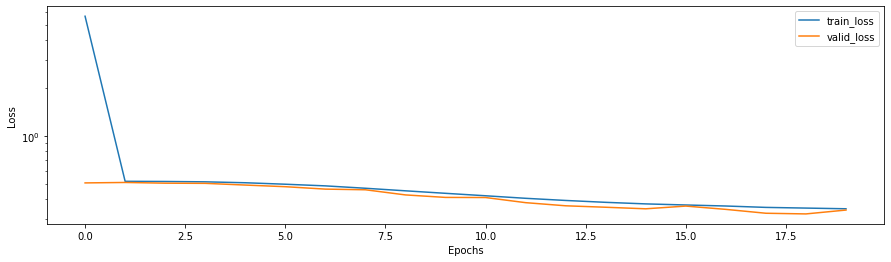

In [15]:
plt.figure(figsize=(15, 4))
plt.yscale('log')
plt.plot(range(len(train_loss)), train_loss, label='train_loss')
plt.plot(range(len(valid_loss)), valid_loss, label='valid_loss')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

* ### 模型預測（Model predictions）

In [16]:
y_pred = model(X_valid)
print(f'預測結果： {y_pred[:5, 0]}')
print(f'目標值： {y_valid[:5]}')

預測結果： [6.5391455 6.331247  6.367708  6.0646486 6.349239 ]
目標值： [7.3414596  5.91434267 6.29165208 5.92219305 6.09744492]


* ### 視覺化結果

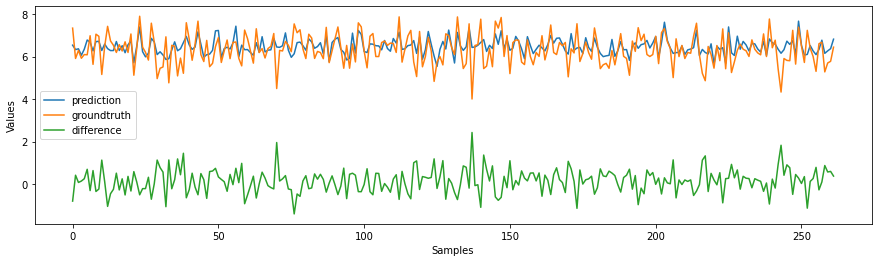

In [17]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(y_pred)), y_pred, label='prediction')
plt.plot(range(len(y_valid)), y_valid, label='groundtruth')
plt.plot(range(len(y_pred)), y_pred[:, 0]-y_valid, label='difference')

plt.legend()
plt.xlabel('Samples')
plt.ylabel('Values')
plt.show()